In [1]:
import pandas as pd

errorlogs = pd.read_pickle('errlogs.pkl')
# found thanks to clustering! 
suspicious_cids = [70715, 70716, 74459, 74460, 74461, 74463, 74464]
for cid in suspicious_cids:
    errorlogs = errorlogs[errorlogs.cid != cid]


In [2]:
len(errorlogs)

3531

In [3]:
errorlogs.loc[3]['error_message']

'make[4]: flex: Command not found\nmake[4]: *** [/TuxML/linux-4.13.3/drivers/scsi/aic7xxx/aicasm//aicasm_scan.c] Error 127\nmake[3]: *** [drivers/scsi/aic7xxx/aicasm/aicasm] Error 2\nmake[2]: *** [drivers/scsi/aic7xxx] Error 2\nmake[1]: *** [drivers/scsi] Error 2\nmake[1]: *** Waiting for unfinished jobs....\nmake: *** [drivers] Error 2\n'

In [4]:
from enum import Enum, auto
class ErrorLog(Enum):
    BLACKLIGHT = auto(),
    BLACKLIGHT2 = auto(),
    CONFIG_NLS_DEFAULT = auto(),
    CRC32 = auto(),
    V4L2 = auto(), 
    OVERFLOW2 = auto(), 
    ULPI = auto(), 
    PCM = auto(),
    TTM = auto(), 
    AS68K = auto(), 
    GEN = auto(), 
    AICDB = auto(), 
    AIC7XXX = auto(),
    DRM_BRIDGE = auto(),
    PINCTRL = auto(), 
    BTBCM = auto(),
    BPFFANCY = auto(), 
    DEVM = auto(), 
    DEVM2 = auto(), 
    I2C = auto() 
    


    

patterns = { ErrorLog.BLACKLIGHT : "undefined reference to `backlight_device",
            ErrorLog.BLACKLIGHT2: 'intel_backlight_device_register', # cid 87044 does not match BACKLIGHT 
            ErrorLog.CONFIG_NLS_DEFAULT : "CONFIG_NLS_DEFAULT",
            ErrorLog.CRC32 : 'undefined reference to `crc32', 
            ErrorLog.V4L2 : 'undefined reference to `v4l2',
            ErrorLog.OVERFLOW2 : '__read_overflow2',
            ErrorLog.ULPI : 'undefined reference to `ulpi', # 100-126K dataset
            ErrorLog.PCM : 'undefined reference to `atmel_pcm_dma_platform', # 100-126K dataset
            ErrorLog.TTM : 'undefined reference to `ttm', 
            ErrorLog.AS68K: 'as68k: not found',
            ErrorLog.GEN : 'undefined reference to `gen_pool', 
            ErrorLog.AIC7XXX: 'drivers/scsi/aic7xxx',
            ErrorLog.AICDB : 'aicdb.h: No such file or directory', 
            ErrorLog.DRM_BRIDGE : 'undefined reference to `drm_panel_bridge_add', 
            ErrorLog.PINCTRL : 'pinctrl-mcp23s08', # loosely pattern (too general?)
            ErrorLog.BTBCM : 'undefined reference to `btbcm_set_bdaddr', 
            ErrorLog.BPFFANCY : 'bpf-fancy', # loosely pattern (too general?)
            ErrorLog.DEVM : 'undefined reference to `__devm_regmap',
            ErrorLog.I2C: 'i2c_get_adapter',
            ErrorLog.DEVM2 : 'undefined reference to `devm_of_led'
           }

pattern_name = [name for name, member in ErrorLog.__members__.items()]
error_pattern = pd.DataFrame(columns=pattern_name, index=errorlogs['cid'])
error_pattern.fillna(False, inplace=True)

for i, errorlog in errorlogs.iterrows():
    error = errorlog['error_message']
    cid = errorlog['cid']
    for k, p in patterns.items():
        if (p in error):
            error_pattern.loc[cid][k.name] = True
            #print (k.name, "found in configuration", cid)
            
            
            


In [5]:
#error_pattern.loc[99949]['BLACKLIGHT'] = True
error_pattern['CONFIG_NLS_DEFAULT'].value_counts()
#error_pattern.hist()

False    3526
True        5
Name: CONFIG_NLS_DEFAULT, dtype: int64

BLACKLIGHT              10
BLACKLIGHT2            209
CONFIG_NLS_DEFAULT       5
CRC32                    2
V4L2                     9
OVERFLOW2               86
ULPI                     0
PCM                      0
TTM                     11
AS68K                  550
GEN                    279
AICDB                 2514
AIC7XXX               2693
DRM_BRIDGE               3
PINCTRL                150
BTBCM                    2
BPFFANCY                 2
DEVM                     2
DEVM2                    1
I2C                    417
dtype: int64

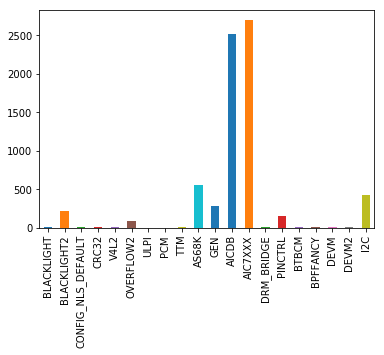

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline  

def nb_patterns(row):
    return sum(row == True)                    
error_pattern['nb_patterns'] = error_pattern.apply(nb_patterns, axis=1)
pattern_frequencies = error_pattern[pattern_name].apply(nb_patterns, axis=0)
pattern_frequencies.plot(kind='bar')
pattern_frequencies

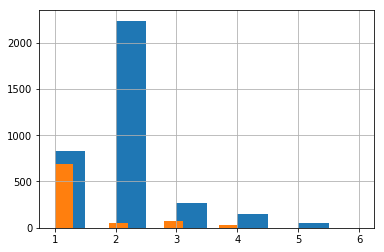

In [7]:
error_pattern['nb_patterns'].hist()
error_pattern.query("AIC7XXX == False")['nb_patterns'].hist()

In [8]:
error_pattern.sort_values(by='nb_patterns', ascending=False)[:20]

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
37984,False,True,False,False,False,False,False,False,False,True,...,True,True,False,True,False,False,False,False,True,6
71259,False,True,False,False,False,False,False,False,False,True,...,True,True,False,True,False,False,False,False,True,6
81014,False,True,False,False,False,False,False,False,False,True,...,True,True,False,False,False,False,False,False,True,5
71037,False,False,False,False,False,False,False,False,False,True,...,True,True,False,True,False,False,False,False,True,5
71059,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,False,True,5
51509,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,False,True,5
61453,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,False,True,5
71396,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,False,True,5
51884,False,True,False,False,False,False,False,False,False,False,...,True,True,False,True,False,False,False,False,True,5


In [9]:
#error_pattern['CONFIG_NLS_DEFAULT'].value_counts().plot(kind='bar')
error_pattern.query('nb_patterns == 0')

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,


In [10]:
error_pattern.query('nb_patterns == 0').shape

(0, 21)

In [11]:
for cid in error_pattern.query('nb_patterns == 0').index:
    print ("configuration cid", cid)
    #if cid in suspicious_cids:
    #    print("false positive failure")
    #    continue
    
    error_message = errorlogs.query("cid == " + str(cid))['error_message'].values
    for err in error_message[0].splitlines():
        if "Cyclomatic" not in err:
            print (err)
    print()
    print()
    print()
    
# 74459, 74460, 74461, 74463, 74464

In [12]:
error_pattern.query('nb_patterns >= 2 & (AS68K == True & AIC7XXX == False)').sort_values(by='nb_patterns', ascending=False)



,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
59966,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,4
53352,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,4
83185,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,4
76001,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,4
46934,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,4
73349,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,4
71787,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,4
66532,False,True,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,4
31459,False,False,False,False,False,False,False,False,False,True,...,False,False,False,True,False,False,False,False,True,3


In [13]:
#error_pattern.query('nb_patterns == 2 & (as68k == False & AIC7XXX == True)').sort_values(by='nb_patterns', ascending=False)
error_pattern.query('nb_patterns >= 2 & (AS68K == False & AICDB == False & AIC7XXX == True)').sort_values(by='nb_patterns', ascending=False)


,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
59582,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,5
33193,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,4
31843,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,4
67934,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,4
53739,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,4
44596,False,True,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,4
68861,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,4
31298,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,3
32197,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,3


In [14]:
error_pattern.query('nb_patterns >= 2 & (AS68K == False & AIC7XXX == False)').sort_values(by='nb_patterns', ascending=False)


,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
99287,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
84163,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
75995,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
66910,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
57668,False,True,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
78821,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
47369,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
80545,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
80885,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4


In [15]:
# masking effect
error_pattern.query('nb_patterns >= 2 & CONFIG_NLS_DEFAULT == True').sort_values(by='nb_patterns', ascending=False)
error_pattern.query('CONFIG_NLS_DEFAULT == True').sort_values(by='nb_patterns', ascending=False)


,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
44596,False,True,True,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,4
52277,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
60391,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
62743,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
99949,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [16]:
# masking effect
error_pattern.query('GEN == True').sort_values(by='nb_patterns', ascending=False)

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
59582,False,True,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,5
84163,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
68861,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,4
66910,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
75995,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
44678,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
60735,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
67934,False,False,False,False,False,False,False,False,False,False,...,False,True,False,True,False,False,False,False,True,4
53739,False,True,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,True,4


In [17]:
error_pattern.query('BLACKLIGHT == True').sort_values(by='nb_patterns', ascending=False)

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
66938,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
59503,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
64086,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
67750,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
75145,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
81720,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
89618,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
93674,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2
98215,True,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,2


In [18]:
# nice masking effect!
error_pattern.query('PINCTRL == True & (AS68K == False & AIC7XXX == False)').sort_values(by='nb_patterns', ascending=False)

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
31080,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
56341,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
87074,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
84163,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
80885,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
80545,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
78821,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
75995,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4
66910,False,True,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,True,4


In [19]:
# nice masking effect!
error_pattern.query('I2C == True & (PINCTRL == False & AS68K == False & AIC7XXX == False)').sort_values(by='nb_patterns', ascending=False)

,BLACKLIGHT,BLACKLIGHT2,CONFIG_NLS_DEFAULT,CRC32,V4L2,OVERFLOW2,ULPI,PCM,TTM,AS68K,...,AICDB,AIC7XXX,DRM_BRIDGE,PINCTRL,BTBCM,BPFFANCY,DEVM,DEVM2,I2C,nb_patterns
cid,,,,,,,,,,,,,,,,,,,,,
99203,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
62326,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
78680,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
56072,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
56432,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
56433,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
58323,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
35459,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
60609,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,True,3
